In [1]:
cd ..


/home/bvandelft/Projects/Audio/clearaudio


In [2]:
import torchaudio
import torchaudio.sox_effects as sox
import torchaudio.transforms as T
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch import Tensor
from typing import Any, List, Tuple, Dict
import numpy as np

import IPython
from clearaudio.viz import plots

In [3]:
class SoxEffectTransform(nn.Module):
    # http://sox.sourceforge.net/sox.html
    # https://pytorch.org/audio/stable/sox_effects.html
    # https://pysox.readthedocs.io/en/latest/api.html
    # https://webaudio.github.io/Audio-EQ-Cookbook/audio-eq-cookbook.html

    def __init__(self, name: str = ""):
        super().__init__()
        self.name = name
        self.effects: List[List[str]] = []

    def reset(self):
        self.effects = []

    @staticmethod
    def from_config(cfg: Any):
        transforms = {}
        for mode in ['train','test','validation']:
            if cfg.dataset.low_quality_effect[mode]:
                transforms[mode] = []
                for effect in cfg.dataset.low_quality_effect[mode]['effects']:
                    sox = SoxEffectTransform(effect.name)
                    for param_string in effect.params:
                        params = param_string.strip().split(" ")
                        sox.add_effect(params)
                    if cfg.dataset.normalize_inputs_post_eq:
                        sox.normalize_gain()
                    transforms[mode].append(sox)
        return transforms

    def to_mono(self, prepend: bool = True):
        """If prepend is True, the first effect will transform the audio to mono and then apply the effects"""
        effect = ["remix", "-"]
        if prepend:
            self.effects.insert(0, effect)
        else:
            self.effects.append(effect)
        return self

    def add_equalizer(self, center_freq: float, gain: float, Q: float = 0.707) :
        """
        Apply a two-pole peaking equalisation (EQ) filter. With this filter, the signal-level at and around a selected frequency can be increased or decreased, whilst (unlike band-pass and band-reject filters) that at all other frequencies is unchanged.
        frequency gives the filter’s central frequency in Hz, width, the band-width, and gain the required gain or attenuation in dB. Beware of Clipping when using a positive gain

        Taken from: https://howtoeq.wordpress.com/2010/10/07/q-factor-and-bandwidth-in-eq-what-it-all-means/
        Q factor (float) controls the bandwidth—or number of frequencies—that will be cut or boosted by the equaliser. The lower the Q factor, the wider the bandwidth (and the more frequencies will be affected).
        The higher the Q factor, the narrower the bandwidth (and the fewer frequencies will be affected).
        Q-factor
        0.7  = 2 octaves
        1    = 1 1/3 octaves
        1.4  = 1 octave
        2.8  = 1/2 octave
        4.3  = 1/3 octave
        8.6  = 1/6 octave
        """
        effect = ["equalizer", str(center_freq), str(Q), str(gain)]
        self.effects.append(effect)
        return self

    def add_overdrive(self, gain: float, colour: float):
        """
        gain (float) desired gain at the boost (or attenuation) in dB [0 to 100]
        colour	(float): controls the amount of even harmonic content in the over-driven output [0, 100]
        """
        effect = ["overdrive", str(gain), str(colour)]
        self.effects.append(effect)
        return self

    def add_effect(self, effect: List[Any]):
        effect = list(map(lambda x: str(x), effect))
        self.effects.append(effect)
        return self

    def normalize_gain(self, level: float = None):
        effect = ["gain", "-n"]
        if level is not None:
            effect.append(str(level))
        self.effects.append(effect)
        return self

    def add_gain(self, gain: float = 0):
        effect = ["gain", str(gain)]
        self.effects.append(effect)
        return self

    def apply_tensor(self, tensor: Tensor, sample_rate: int) -> Tuple[Tensor, int]:
        return sox.apply_effects_tensor(tensor, sample_rate, self.effects, channels_first=True)

    def forward(self, tensor: Tensor, sample_rate: int) -> Tuple[Tensor, int]:
        return self.apply_tensor(tensor, sample_rate)

    def apply_file(self, filepath: str) -> Tuple[Tensor, int]:
        return sox.apply_effects_file(filepath, self.effects, channels_first=True)

    def process_file(self, input_filepath: str, output_folder: str, override: bool = False) -> str:
        """Apply effect directly on an audio file and creates the transformed version by
        using the original name and self.name returns the filepath of the transformed file
        if transformed file already exists skip unless override is True
        """
        eq_name = self.name
        if not eq_name:
            eq_name = "eq_def"
        inpath = Path(input_filepath)
        filename = str(inpath.stem)
        ext = inpath.suffix

        # Create folder if needed
        outfolder = Path(output_folder)
        outfolder.mkdir(parents=True, exist_ok=True)

        output_path = outfolder / (filename + "_" + eq_name + ext)
        if output_path.exists() and not override:
            LOG.info(f"File exist, skipping: {output_path}")
            return str(output_path)

        waveform, sr = self.apply_file(input_filepath)
        torchaudio.save(output_path, waveform, sr)
        LOG.info(f"Wrote: {output_path}")
        return str(output_path)

In [4]:
sample = torchaudio.load("samples/hq/sample1.wav")
sample = [sample[0][:,:131000],sample[1]]
IPython.display.Audio(sample[0].detach(), rate=sample[1])

torch.Size([1, 131000])


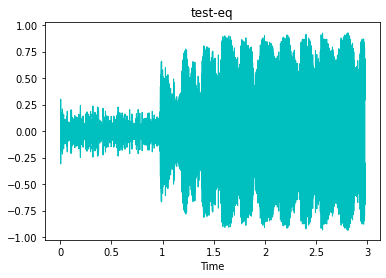

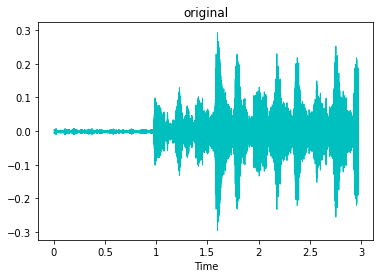

In [23]:
# eq =  ["equalizer 200 0.7 20", "equalizer 450 20 30", "treble -30 4000 1"]
# eq = ["echos 1. 0.7 700 0.9" 700 0.3 700 0.3 700 0.3 700 0.3"]
# eq = ["reverb 89 13 98 60 207 14"]
# eq += ['channels 1']
# eq = ['sinc -a 40 -1000']
# eq = ["band -n 1000 100"]
# eq = ['tremolo 2000 70']
# eq = ['riaa']
# eq = ['flanger']
eq = ['bass 30 1000 0.9']
eq += ['overdrive 7 10']
eq += ['treble -30 3000 0.5']
#tremolo, sinc, riaa, hilbert, flanger, echos, band
transform = SoxEffectTransform('Test')
for equalizer in eq:
    params = equalizer.strip().split(" ")
    transform.add_effect(params)
    lq_wave, lq_sample_rate = transform.apply_tensor(sample[0][0].unsqueeze(0), sample[1])
print(lq_wave.size())
plots.plot_waveform(lq_wave, lq_sample_rate, title="test-eq", color='c')
plots.plot_waveform(sample[0], sample[1], title="original", color='c')
IPython.display.Audio(lq_wave.detach(), rate=sample[1])